In [1]:
import pandas as pd
import os
from common import data_folder_path
import matplotlib.pyplot as plt
import numpy as np

data_file = 'train.csv'
df = pd.read_csv(os.path.join(data_folder_path,data_file))
df['datetime'] = pd.to_datetime(df['datetime'])
df['Time of Day']=df['datetime'].dt.hour
df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,Time of Day
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,0
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,0
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,0
...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,23
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,23
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,23
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,23


In [3]:
product_type_3_df = df[df['product_type']==3]
product_type_3_df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,Time of Day
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,0
5,0,0,3,656.859,1,2021-09-01 00:00:00,0,5,2,0
10,0,1,3,0.315,0,2021-09-01 00:00:00,0,10,5,0
11,0,1,3,5155.056,1,2021-09-01 00:00:00,0,11,5,0
14,1,0,3,0.087,0,2021-09-01 00:00:00,0,14,7,0
...,...,...,...,...,...,...,...,...,...,...
2018341,14,1,3,1242.600,1,2023-05-31 23:00:00,637,2018341,56,23
2018344,15,0,3,2.287,0,2023-05-31 23:00:00,637,2018344,58,23
2018345,15,0,3,117.332,1,2023-05-31 23:00:00,637,2018345,58,23
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,23


In [4]:
def get_dist_df(df,z=1.96, is_consumer=0,is_business=0,clip = True):
    if is_consumer is None:
        if is_business is None:
            mean_df = pd.DataFrame(df.groupby(['Time of Day'])['target'].mean())
            std_df = pd.DataFrame(df.groupby(['Time of Day'])['target'].std())
        else:
            mean_df = pd.DataFrame(df[(df['is_business']==is_business)].groupby(['Time of Day'])['target'].mean())
            std_df = pd.DataFrame(df[(df['is_business']==is_business)].groupby(['Time of Day'])['target'].std())
    else:
        if is_business is None:
            mean_df = pd.DataFrame(df[(df['is_consumption']==is_consumer)].groupby(['Time of Day'])['target'].mean())
            std_df = pd.DataFrame(df[(df['is_consumption']==is_consumer)].groupby(['Time of Day'])['target'].std())
        else:
            mean_df = pd.DataFrame(df[(df['is_consumption']==is_consumer)&(df['is_business']==is_business)].groupby(['Time of Day'])['target'].mean())
            std_df = pd.DataFrame(df[(df['is_consumption']==is_consumer)&(df['is_business']==is_business)].groupby(['Time of Day'])['target'].std())


    pivot_mean_df = pd.pivot_table(mean_df.reset_index(),values='target',index='Time of Day')
    pivot_std_df = pd.pivot_table(std_df.reset_index(),values='target',index='Time of Day')
    pivot_dist_df = pivot_mean_df.copy()
    sample_size = pd.DataFrame(df.groupby(['Time of Day']).size()).rename(columns={0:'target'})

    pivot_dist_df['lower_range'] = pivot_mean_df - z*pivot_std_df/(sample_size**0.5)
    pivot_dist_df['upper_range'] = pivot_mean_df + z*pivot_std_df/(sample_size**0.5)

    if clip:
        pivot_dist_df=pivot_dist_df.clip(0)

    return pivot_dist_df

In [5]:
distribution_dfs = {}
for is_consumer in [0,1]:
    distribution_dfs[is_consumer] = {}
    for is_business in [0,1]:
        pivot_dist_df = get_dist_df(product_type_3_df,z=1.96, is_consumer=is_consumer,is_business=is_business,clip = True)
        pivot_dist_df.to_csv(os.path.join(data_folder_path,'pivot_dist_df_{}_{}.csv'.format(is_consumer,is_business)))
        distribution_dfs[is_consumer][is_business] = pivot_dist_df

In [6]:
def plot_distribution(pivot_dist_df,ax,title,ylabel='Target'):
    ax.plot(pivot_dist_df.index,pivot_dist_df['target'],label='mean')
    ax.fill_between(pivot_dist_df.index,pivot_dist_df['lower_range'],pivot_dist_df['upper_range'],alpha=0.3,label='95% CI')
    ax.set_title(title)
    ax.set_xlabel('Time of Day')
    ax.set_ylabel(ylabel)
    ax.legend()

In [7]:
def get_distribution_plot_title(is_consumer,is_business):
    if is_consumer==0:
        is_consumer = 'Producer'
    else:
        is_consumer = 'Consumer'
    if is_business==0:
        is_business = 'Non-Business'
    else:
        is_business = 'Business'
    return '{} {}'.format(is_consumer,is_business)

def get_distribution_plot_ylabel(is_consumer):
    ylabel = 'Energy'
    if is_consumer==0:
        return ylabel+' Production'
    else:
        return ylabel+' Consumption'
    
def plot_distributions(distribution_dfs):
    fig,ax = plt.subplots(2,2,figsize=(15,15))
    for i,is_consumer in enumerate([0,1]):
        for j,is_business in enumerate([0,1]):
            plot_distribution(distribution_dfs[is_consumer][is_business],ax[i][j],
                title=get_distribution_plot_title(is_consumer,is_business),
                ylabel=get_distribution_plot_ylabel(is_consumer))
    plt.show()

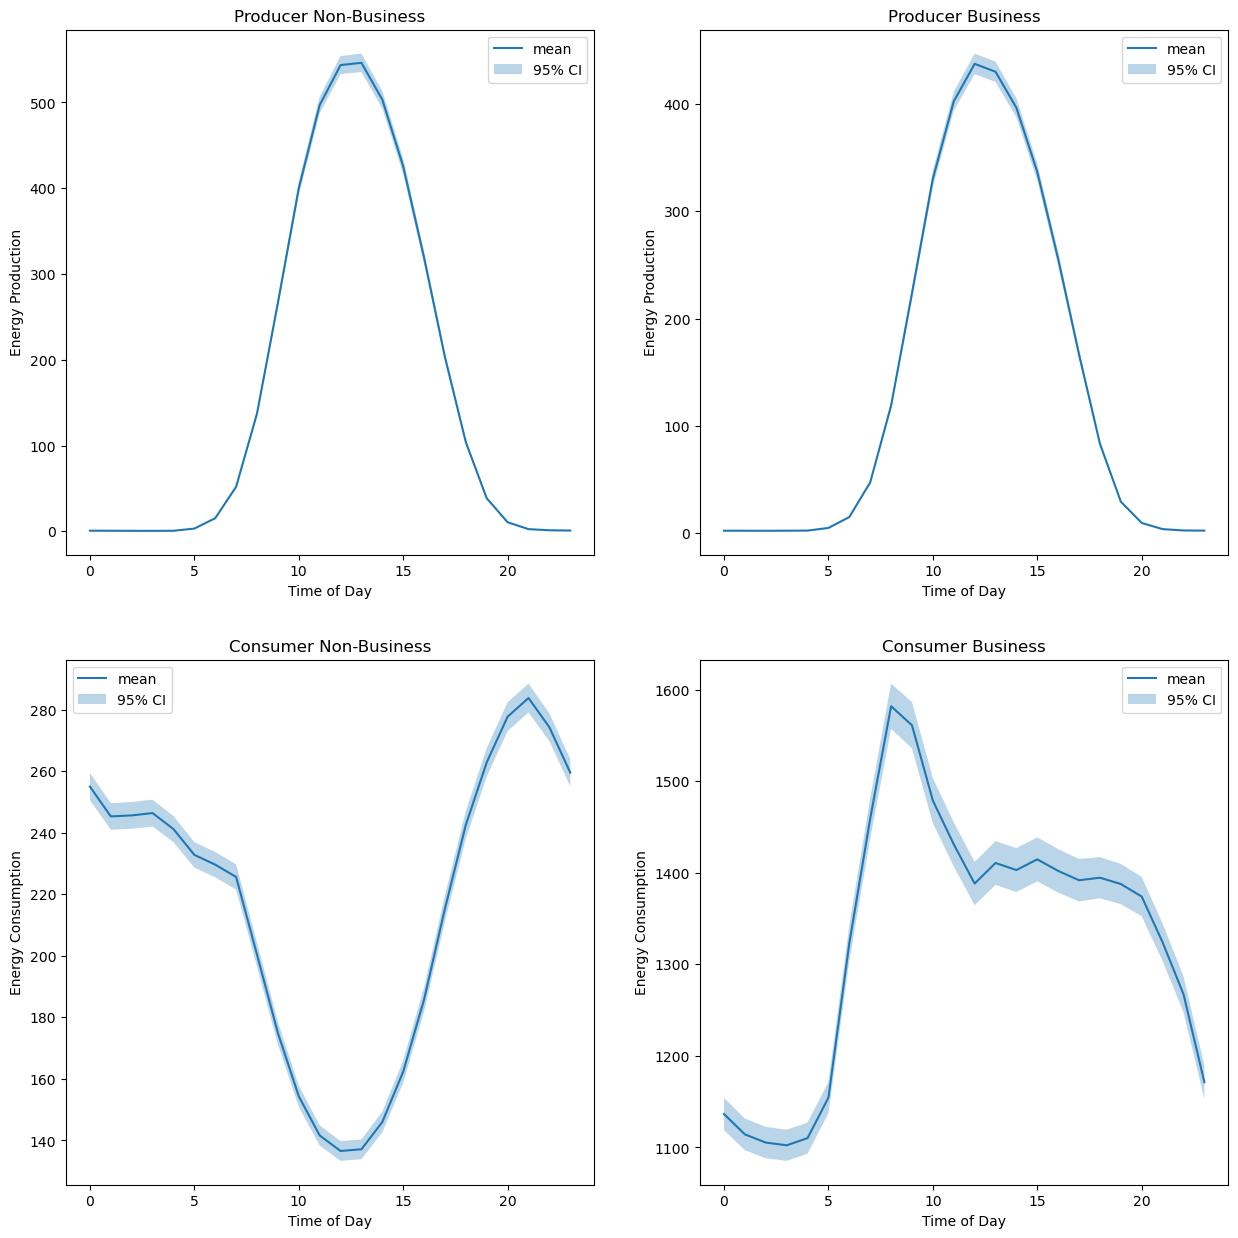

In [8]:
plot_distributions(distribution_dfs)

In [10]:
#above charts are extremely similar to the overall distribution, just at higher levels across the board

#does seasonality differ from the overall distribution?
#based on this https://seasonsyear.com/Estonia
def get_season(row):
    month = row.month
    if month in [12,1,2,3]: #'Snow starts to fall at around middle of December and remains to mid-March. By the beginning of December temperature of water finally drops below zero (0C) thus the ice begins to appear by the coasts.'
        return 'Winter'
    elif month in [4,5]:
        return 'Spring'
    elif month in [6,7,8]:
        return 'Summer' #'Climate of the summer months: ... June ... July ... August'
    else:
        return 'Autumn' #'In Estonia coming of actual Autumn is almost simultaneous to calendar change of seasons.'

product_type_3_df['Season'] = product_type_3_df['datetime'].apply(get_season)
product_type_3_df['Season'].value_counts()#.plot(kind='bar')
assert product_type_3_df['Season'].value_counts().sum()==product_type_3_df.shape[0] #sanity check that all rows have a season

C:\Users\Joe\AppData\Local\Temp\ipykernel_14980\252831617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_type_3_df['Season'] = product_type_3_df['datetime'].apply(get_season)


<Axes: title={'center': 'Energy Production by Season'}, xlabel='Time of Day'>

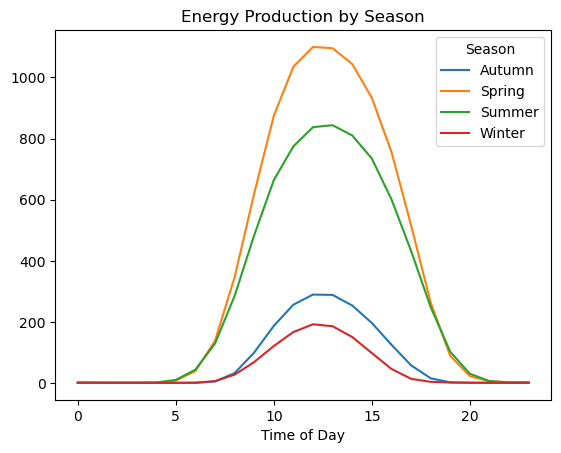

In [11]:
product_type_3_df[product_type_3_df['is_consumption']==0].groupby(['Season','Time of Day'])['target'].mean().unstack().transpose().plot(kind='line',title='Energy Production by Season')

<Axes: title={'center': 'Energy Production by Season'}, xlabel='Time of Day'>

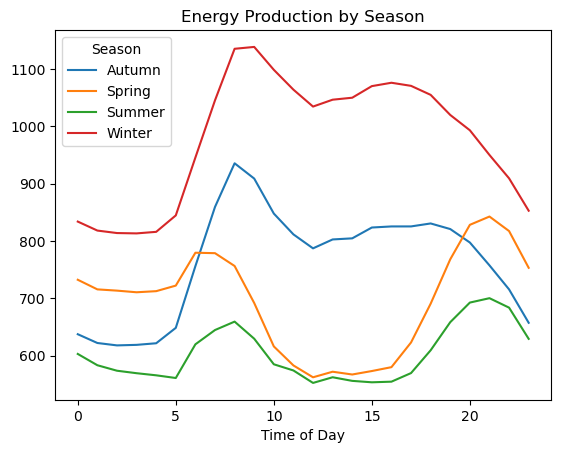

In [12]:
product_type_3_df[product_type_3_df['is_consumption']==1].groupby(['Season','Time of Day'])['target'].mean().unstack().transpose().plot(kind='line',title='Energy Production by Season')

<Axes: title={'center': 'Business Energy Consumption by Season'}, xlabel='Time of Day'>

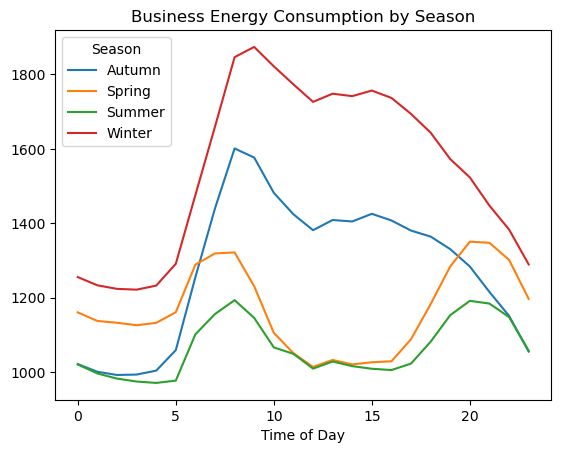

In [13]:
#nope, same thing - just higher levels across the board
product_type_3_df[(product_type_3_df['is_business']==1)&(product_type_3_df['is_consumption']==1)].groupby(['Season','Time of Day'])['target'].mean().unstack().transpose().plot(kind='line',title='Business Energy Consumption by Season')

<Axes: title={'center': 'Non-Business Energy Consumption by Season'}, xlabel='Time of Day'>

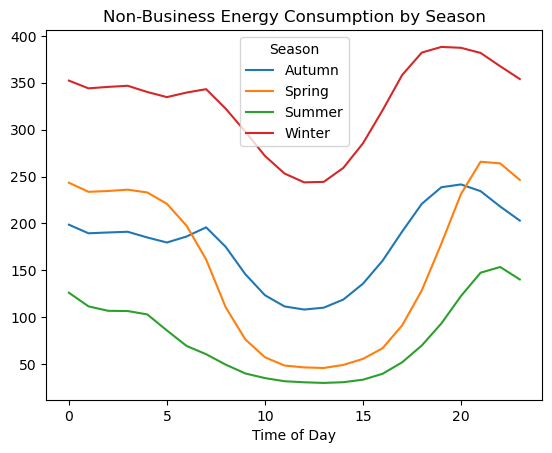

In [14]:
product_type_3_df[(product_type_3_df['is_business']==0)&(product_type_3_df['is_consumption']==1)].groupby(['Season','Time of Day'])['target'].mean().unstack().transpose().plot(kind='line',title='Non-Business Energy Consumption by Season')

<Axes: title={'center': 'Business Energy Production by Season'}, xlabel='Time of Day'>

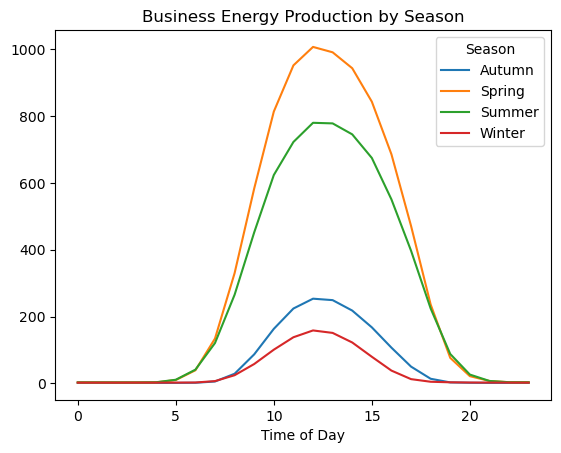

In [15]:
product_type_3_df[(product_type_3_df['is_business']==1)&(product_type_3_df['is_consumption']==0)].groupby(['Season','Time of Day'])['target'].mean().unstack().transpose().plot(kind='line',title='Business Energy Production by Season')

<Axes: title={'center': 'Non-Business Energy Production by Season'}, xlabel='Time of Day'>

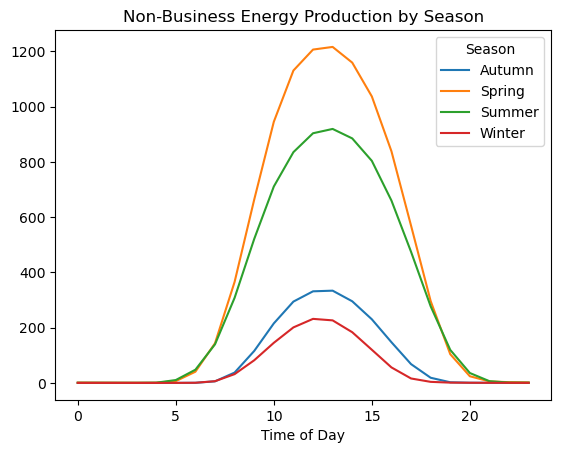

In [16]:
product_type_3_df[(product_type_3_df['is_business']==0)&(product_type_3_df['is_consumption']==0)].groupby(['Season','Time of Day'])['target'].mean().unstack().transpose().plot(kind='line',title='Non-Business Energy Production by Season')

C:\Users\Joe\AppData\Local\Temp\ipykernel_14980\1209804485.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_type_3_df['Day of Week'] = product_type_3_df['datetime'].dt.dayofweek


<Axes: title={'center': 'Non-Business Energy Production by Season'}, xlabel='Day of Week'>

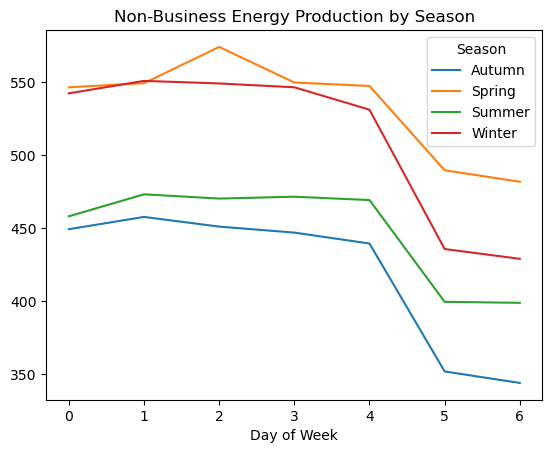

In [22]:
#still no seasonality differences, just higher levels across the board

#what about day of week?
product_type_3_df['Day of Week'] = product_type_3_df['datetime'].dt.dayofweek
product_type_3_df.groupby(['Season','Day of Week'])['target'].mean().unstack().transpose().plot(kind='line',title='Non-Business Energy Production by Season')
